In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 12144.24it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [2]:
from ai2thor.controller import Controller


house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


In [3]:
import numpy as np
def teleport(controller, target=None):
    event = controller.step("GetReachablePositions")
    reachable_positions = event.metadata["actionReturn"]
    # Pick a random target
    if target is None:
        target = np.random.choice(reachable_positions)

    event = controller.step(
        action="TeleportFull",
        x=target["x"],
        y=target["y"],
        z=target["z"],
        rotation={"x": 0, "y": 0, "z": 0},
        horizon=0,
        standing=True
    )

    return event


In [4]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, ClipEnv, CLIPNovelty
from models import LSTMActor, LSTMCritic, FrozenResNetEncoder, SlidingWindowTransformerActor, SlidingWindowTransformerCritic
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS, DEVICE

In [5]:
import torch
import matplotlib.pyplot as plt
from rl import save_actor_critic

def train(controller, name: str, ppo: PPO, env: Env, actor_critic: ActorCritic, total_updates=10):
    event = controller.step("Pass")  # prime
    rewards = []
    episode_rewards = []
    for upd in range(total_updates):
        buf = RolloutBuffer()
        for mb in range(MINIBATCHES):
            # collect episodes
            episode_seq = []
            episode_reward = 0
            actions_seq = []
            for t in range(1, EPISODE_STEPS + 1):
                with torch.no_grad():
                    obs_t = ppo.obs_from_event(event)  # (C,H,W)
                    obs_t_encoded = actor_critic.actor_critic_encoder(obs_t.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
                    obs_seq = torch.stack(episode_seq + [obs_t_encoded], dim=0).unsqueeze(0).to(device=DEVICE)

                if len(actions_seq) == 0:
                    actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
                
                actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
                logits, value = ppo.act_and_value(obs_seq, actions_tensor, actor_critic)
                dist = torch.distributions.Categorical(logits=logits)
                action_idx = dist.sample()
                logp = dist.log_prob(action_idx)
                
                action_idx, logp = action_idx.item(), logp.item()
                event, reward = env.step_env(controller, action_idx)
                done = t == EPISODE_STEPS

                # store one step
                buf.add(obs_t_encoded, action_idx, logp, reward, value, done)
                episode_seq.append(obs_t_encoded)
                rewards.append(reward)
                actions_seq.append(action_idx)
                
                episode_reward += reward / EPISODE_STEPS

                # 50% chance of teleport
                if done:
                    env.reset()
                    if np.random.rand() > 0.5:
                        event = teleport(controller)
            episode_rewards.append(episode_reward)
                
        ppo.ppo_update(buf, actor_critic)
        save_actor_critic(actor_critic, name)
        
        print(f"Update {upd+1}/{total_updates} — steps: {len(buf)}")
        plt.plot(rewards)
        plt.show()
        plt.plot(episode_rewards)
        plt.show()
    return buf, rewards

In [6]:
ENTROPY_COEF = 0.05

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)


[PPO] Epoch 0: Loss=76.6440, Policy=0.0068, Value=153.3808
[PPO] Epoch 10: Loss=61.1473, Policy=-0.0005, Value=122.4004
[PPO] Epoch 20: Loss=51.7754, Policy=0.0002, Value=103.6582
[PPO] Epoch 30: Loss=43.3079, Policy=0.0027, Value=86.7181
Approx KL Learned: 0.018709275871515274
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 1/10 — steps: 4096


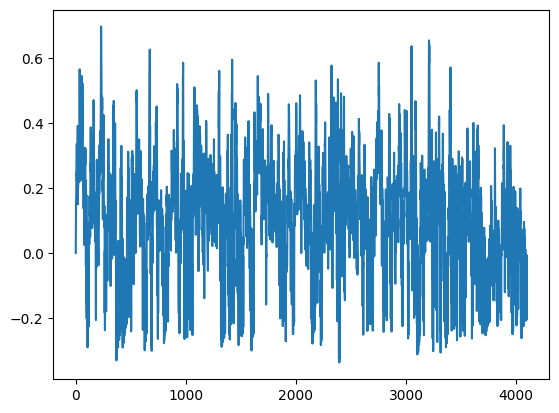

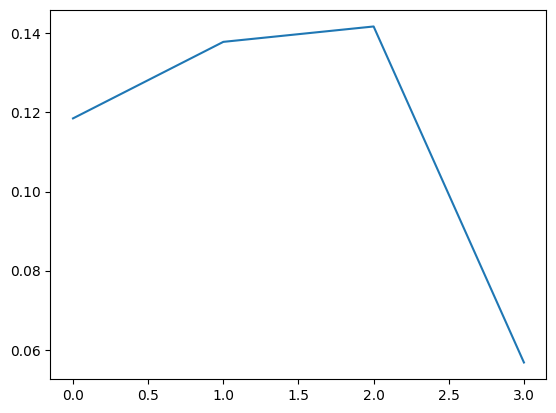

[PPO] Epoch 0: Loss=75.0301, Policy=0.0024, Value=150.1585
[PPO] Epoch 10: Loss=62.8956, Policy=-0.0027, Value=125.9006
[PPO] Epoch 20: Loss=54.6429, Policy=-0.0076, Value=109.4052
[PPO] Epoch 30: Loss=48.3498, Policy=-0.0116, Value=96.8268
Approx KL Learned: 0.014880504459142685
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 2/10 — steps: 4096


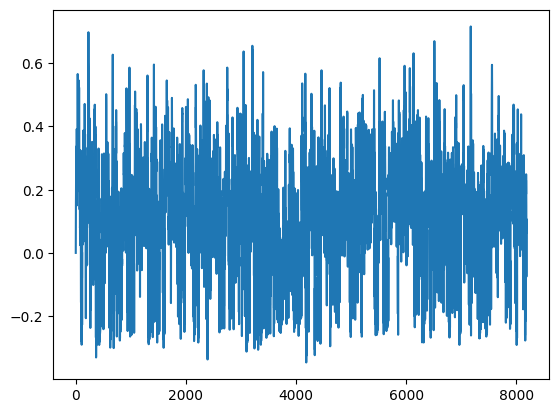

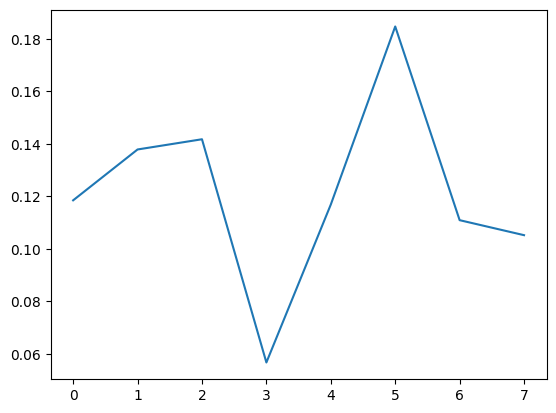

[PPO] Epoch 0: Loss=69.8446, Policy=0.0036, Value=139.7854
[PPO] Epoch 10: Loss=56.5625, Policy=-0.0029, Value=113.2332
[PPO] Epoch 20: Loss=51.8555, Policy=-0.0053, Value=103.8257
[PPO] Epoch 30: Loss=46.9842, Policy=-0.0036, Value=94.0783
Approx KL Learned: 0.016673944890499115
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 3/10 — steps: 4096


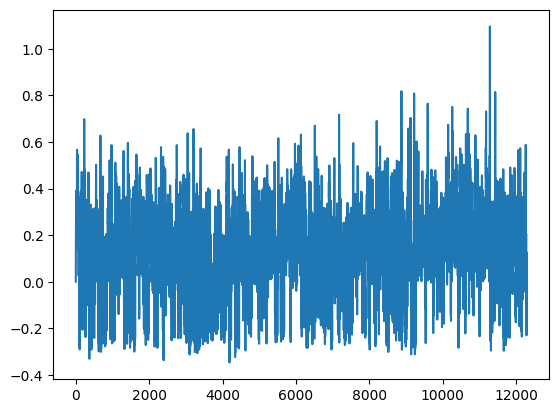

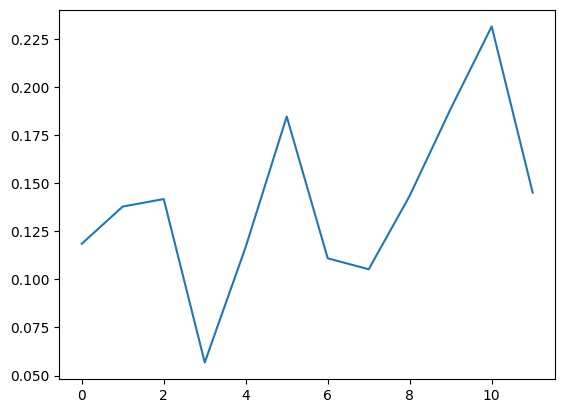

[PPO] Epoch 0: Loss=74.0351, Policy=-0.0004, Value=148.1749
[PPO] Epoch 10: Loss=58.4318, Policy=-0.0042, Value=116.9742
[PPO] Epoch 20: Loss=50.3913, Policy=-0.0074, Value=100.8999
[PPO] Epoch 30: Loss=43.9151, Policy=-0.0105, Value=87.9537
Approx KL Learned: 0.010022655129432678
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 4/10 — steps: 4096


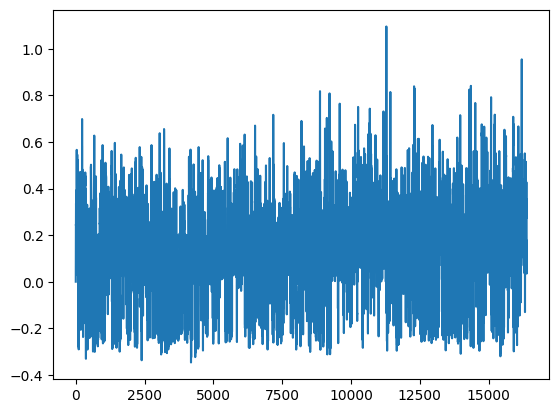

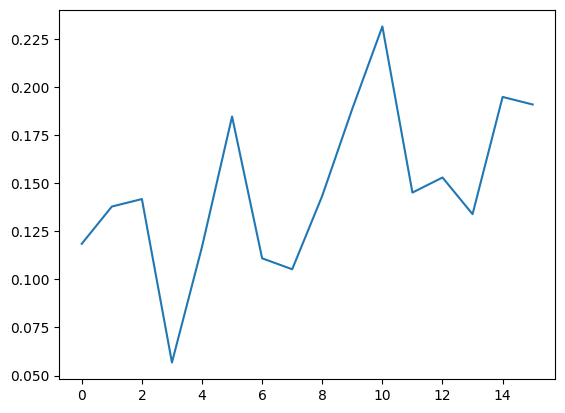

[PPO] Epoch 0: Loss=72.1352, Policy=0.0011, Value=144.3700
[PPO] Epoch 10: Loss=58.1135, Policy=-0.0041, Value=116.3361
[PPO] Epoch 20: Loss=51.3078, Policy=-0.0072, Value=102.7312
[PPO] Epoch 30: Loss=48.0842, Policy=-0.0105, Value=96.2904
Approx KL Learned: 0.01810108870267868
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 5/10 — steps: 4096


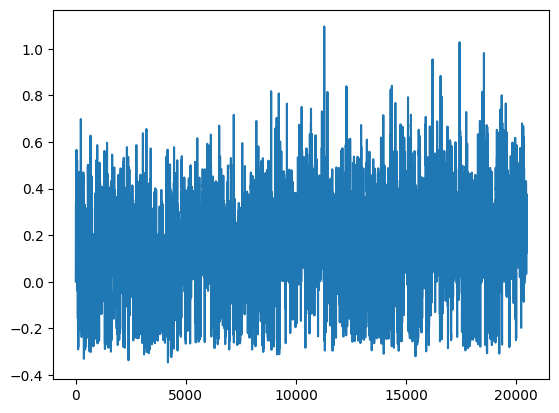

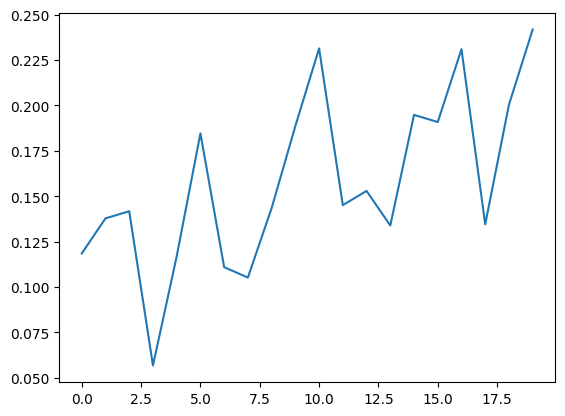

[PPO] Epoch 0: Loss=69.8097, Policy=0.0021, Value=139.7160
[PPO] Epoch 10: Loss=48.1109, Policy=-0.0023, Value=96.3252
[PPO] Epoch 20: Loss=40.5767, Policy=-0.0081, Value=81.2686
[PPO] Epoch 30: Loss=36.9226, Policy=-0.0139, Value=73.9717
Approx KL Learned: 0.016239140182733536
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 6/10 — steps: 4096


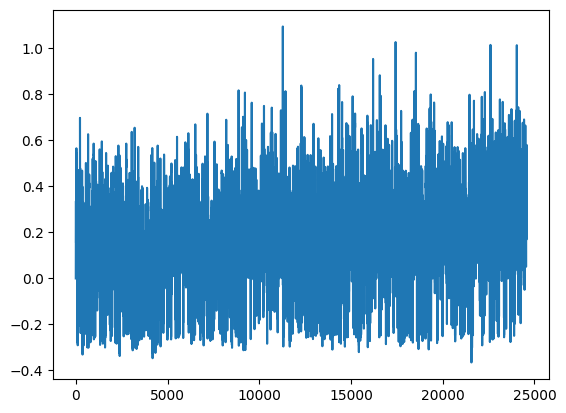

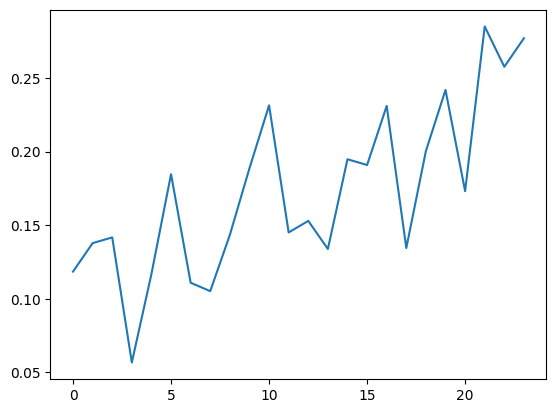

[PPO] Epoch 0: Loss=73.8460, Policy=0.0005, Value=147.7888
[PPO] Epoch 10: Loss=57.2481, Policy=-0.0061, Value=114.6037
[PPO] Epoch 20: Loss=51.3183, Policy=-0.0085, Value=102.7501
[PPO] Epoch 30: Loss=45.7222, Policy=-0.0089, Value=91.5558
Approx KL Learned: 0.032335542142391205
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 7/10 — steps: 4096


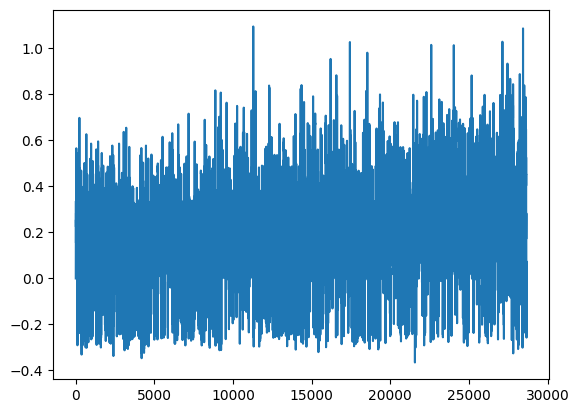

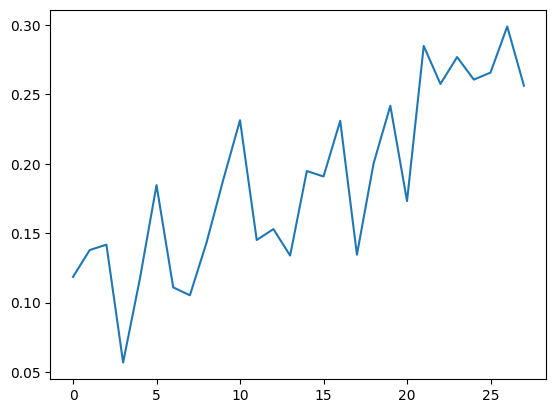

[PPO] Epoch 0: Loss=77.6408, Policy=0.0018, Value=155.3692
[PPO] Epoch 10: Loss=60.8703, Policy=-0.0026, Value=121.8355
[PPO] Epoch 20: Loss=45.1722, Policy=-0.0095, Value=90.4524
[PPO] Epoch 30: Loss=36.8528, Policy=-0.0131, Value=73.8202
Approx KL Learned: 0.016469988971948624
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 8/10 — steps: 4096


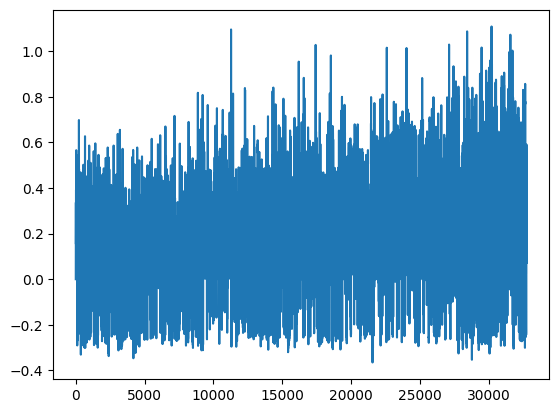

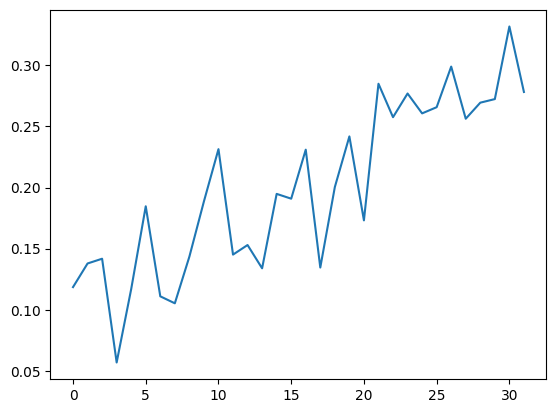

[PPO] Epoch 0: Loss=80.8791, Policy=0.0029, Value=161.8400
[PPO] Epoch 10: Loss=52.2911, Policy=-0.0061, Value=104.6770
[PPO] Epoch 20: Loss=47.2104, Policy=-0.0065, Value=94.5182
[PPO] Epoch 30: Loss=39.8740, Policy=-0.0092, Value=79.8513
Approx KL Learned: 0.012046650983393192
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 9/10 — steps: 4096


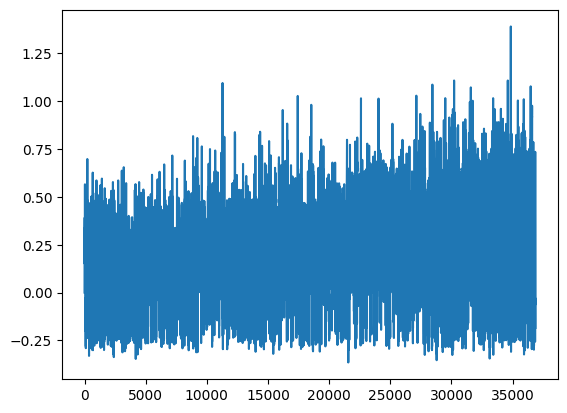

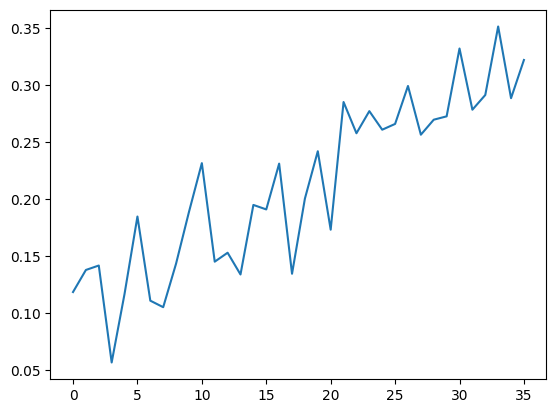

[PPO] Epoch 0: Loss=77.4521, Policy=0.0025, Value=154.9838
[PPO] Epoch 10: Loss=55.6473, Policy=-0.0055, Value=111.3895
[PPO] Epoch 20: Loss=46.6699, Policy=-0.0026, Value=93.4319
[PPO] Epoch 30: Loss=39.7421, Policy=0.0306, Value=79.4968
Approx KL Learned: 0.03573046624660492
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 10/10 — steps: 4096


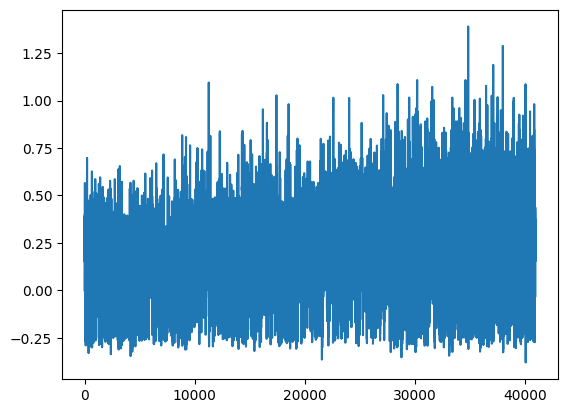

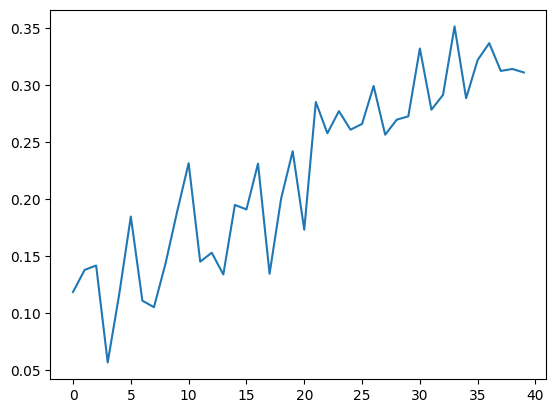

In [7]:
buf, rewards = train(controller, "clip_actor_critic_checkpoint_long_training.pt", ppo, clip_env, clip_actor_critic, 10)

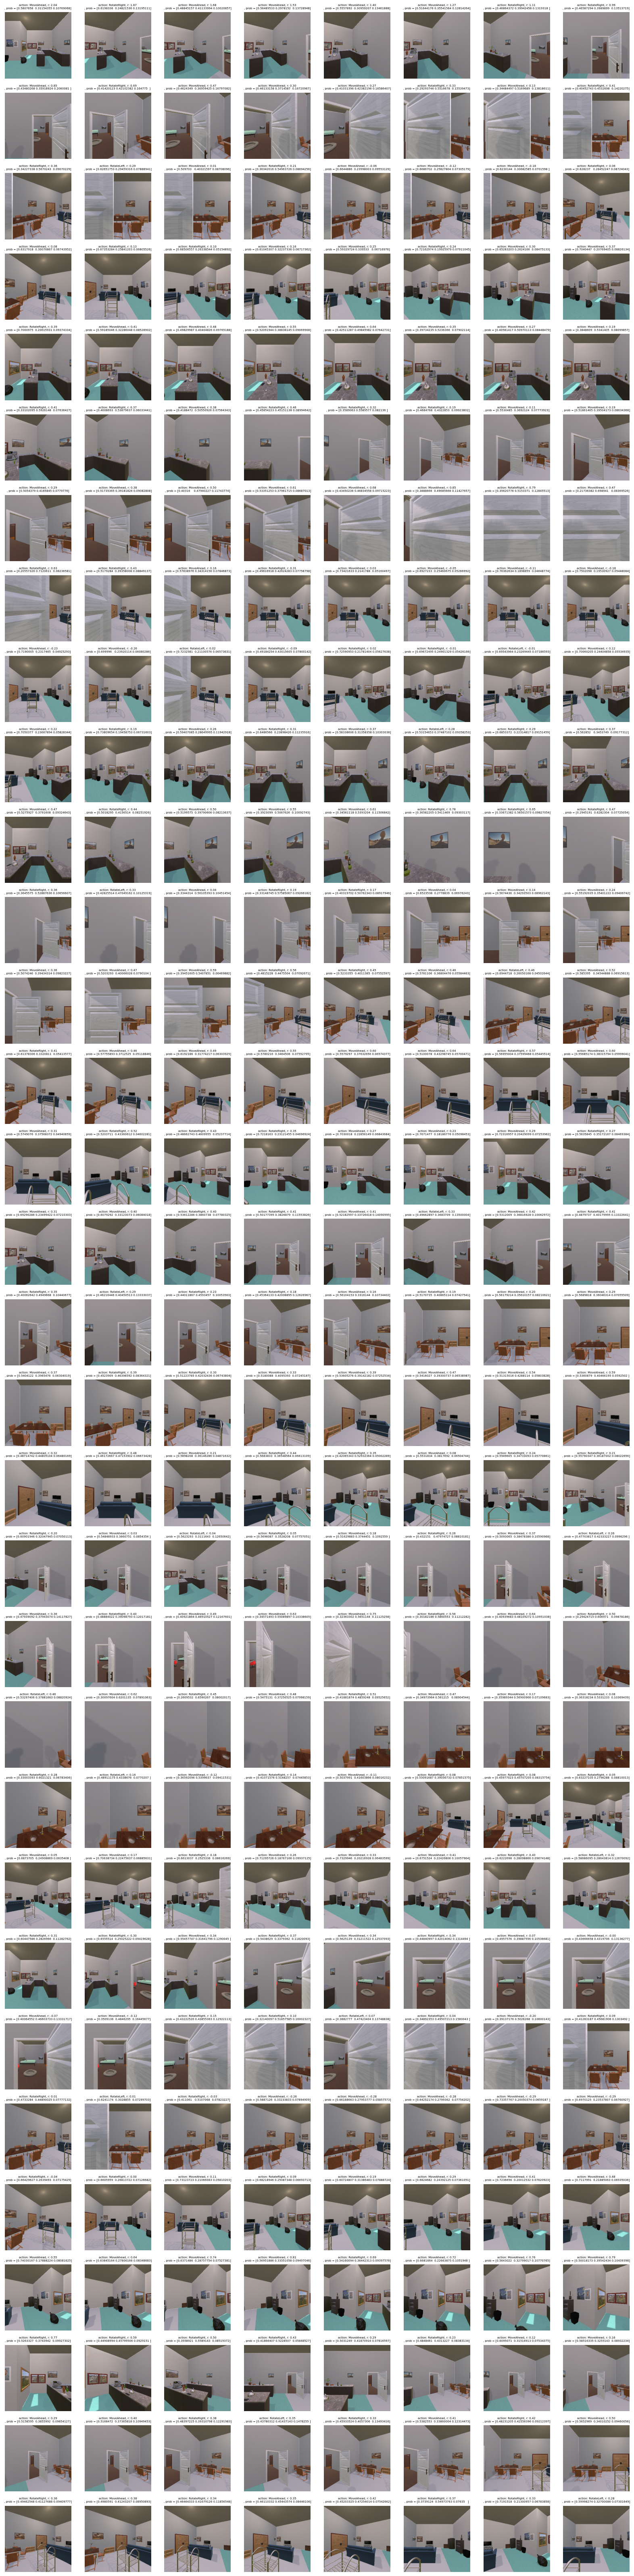

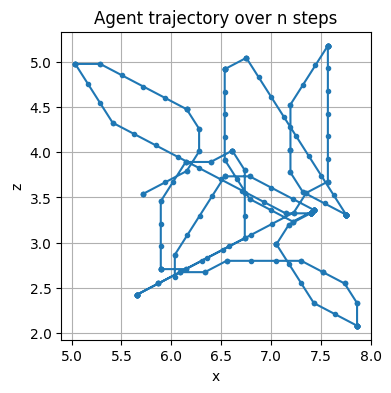

[tensor([[[0.3725, 0.3725, 0.3765,  ..., 0.6078, 0.6078, 0.6078],
          [0.3725, 0.3725, 0.3765,  ..., 0.6078, 0.6078, 0.6078],
          [0.3725, 0.3725, 0.3725,  ..., 0.6078, 0.6078, 0.6078],
          ...,
          [0.3647, 0.3373, 0.3255,  ..., 0.3882, 0.3843, 0.3804],
          [0.3647, 0.3373, 0.3255,  ..., 0.3882, 0.3882, 0.3882],
          [0.3647, 0.3373, 0.3255,  ..., 0.3882, 0.3882, 0.3882]],
 
         [[0.3490, 0.3490, 0.3490,  ..., 0.5843, 0.5843, 0.5843],
          [0.3490, 0.3490, 0.3490,  ..., 0.5804, 0.5804, 0.5804],
          [0.3490, 0.3490, 0.3490,  ..., 0.5804, 0.5804, 0.5804],
          ...,
          [0.3490, 0.3294, 0.3176,  ..., 0.5647, 0.5529, 0.5529],
          [0.3490, 0.3294, 0.3137,  ..., 0.5647, 0.5647, 0.5647],
          [0.3490, 0.3294, 0.3176,  ..., 0.5725, 0.5647, 0.5647]],
 
         [[0.2902, 0.2902, 0.2902,  ..., 0.5882, 0.5882, 0.5882],
          [0.2902, 0.2902, 0.2902,  ..., 0.5882, 0.5882, 0.5882],
          [0.2902, 0.2902, 0.2902,  ...,

In [13]:
from cons import ACTIONS
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
import imageio


def inference(get_distribution: Callable[[torch.Tensor, ActorCritic], torch.distributions.Categorical], init_position: dict[str, float], env: Env, actor_critic: ActorCritic, plot=True):
    n = 256
    n_row = 32
    positions = []

    plt.figure(figsize=(n // n_row * 2, n_row * 2))
    event = teleport(controller, init_position)
    episode_seq = deque(maxlen=EPISODE_STEPS)
    actions_seq = deque(maxlen=EPISODE_STEPS)
    raw_obs = []
    for t in range(1, n + 1):
        positions.append([event.metadata["agent"]["position"]["x"], event.metadata["agent"]["position"]["z"]])
        with torch.no_grad():
            obs_t = ppo.obs_from_event(event)  # (C,H,W)
            obs_t_encoded = actor_critic.actor_critic_encoder(obs_t.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
            obs_seq = torch.stack(list(episode_seq) + [obs_t_encoded], dim=0).unsqueeze(0).to(device=DEVICE)

        if len(actions_seq) == 0:
            actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
        
        actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
        dist = get_distribution(obs_seq, actions_tensor, actor_critic)
        action_idx = dist.sample()
        logp = dist.log_prob(action_idx)
        
        action_idx, logp = action_idx.item(), logp.item()
        event, reward = env.step_env(controller, action_idx)

        # store one step
        episode_seq.append(obs_t_encoded)
        actions_seq.append(action_idx)
        raw_obs.append(obs_t)
        
        if plot:
            # Plot frame and action
            plt.subplot(n_row, n // n_row, t)
            plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}" + "\n, prob = " + f"{torch.exp(dist.log_prob(torch.tensor([0, 1, 2], device=DEVICE))).cpu().numpy()}", fontsize=5)
            plt.axis(False)
            plt.imshow(event.frame)
    if plot:
        plt.tight_layout()
        plt.show()
        
        # ---- Plot 2D trajectory of the agent ----
        positions = np.array(positions)
        plt.figure(figsize=(4, 4))
        plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
        plt.xlabel("x")
        plt.ylabel("z")
        plt.title("Agent trajectory over n steps")
        plt.grid(True)
        plt.show()

    return raw_obs

def inference_video_mp4(
    get_distribution,
    init_position: dict[str, float],
    env: Env,
    actor_critic: ActorCritic,
    video_path="rollout.mp4",
    fps=10,
    n_steps=256
):
    episode_seq = deque(maxlen=EPISODE_STEPS)
    actions_seq = deque(maxlen=EPISODE_STEPS)

    writer = imageio.get_writer(video_path, fps=fps)

    # start episode
    event = teleport(controller, init_position)
    positions = []

    for t in range(1, n_steps + 1):

        # ---- Add current frame to video ----
        writer.append_data(event.frame[:, :, ::-1])   # convert RGB→BGR if needed

        # track positions
        positions.append([
            event.metadata["agent"]["position"]["x"],
            event.metadata["agent"]["position"]["z"],
        ])

        with torch.no_grad():
            obs_t = ppo.obs_from_event(event)  
            obs_enc = actor_critic.actor_critic_encoder(
                obs_t.unsqueeze(0).unsqueeze(0)
            ).squeeze(0).squeeze(0)

            obs_seq = torch.stack(
                list(episode_seq) + [obs_enc], dim=0
            ).unsqueeze(0).to(DEVICE)

        # ---- Action ----
        if len(actions_seq) == 0:
            actions_seq.append(torch.randint(0, NUM_ACTIONS, ()).item())

        actions_tensor = torch.tensor(
            actions_seq, dtype=torch.long, device=DEVICE
        ).unsqueeze(0)

        dist = get_distribution(obs_seq, actions_tensor, actor_critic)
        action_idx = dist.sample().item()

        # ---- Step env ----
        event, reward = env.step_env(controller, action_idx)

        # ---- Store ----
        episode_seq.append(obs_enc)
        actions_seq.append(action_idx)

    writer.close()
    print(f"[🎞️] Saved video to {video_path}")

    return positions


def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
    logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    return dist

event = teleport(controller)
init_pos = event.metadata["agent"]["position"]
inference(get_distributions, init_pos, clip_env, clip_actor_critic)

In [34]:
!pip install imageio imageio-ffmpeg

In [9]:
import clip

model, preprocess = clip.load("ViT-B/32", device=DEVICE)

In [10]:
import torch
import torch.nn.functional as F
import random

def preprocess_clip(x):
    # Resize to CLIP resolution
    x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)
    # Normalize (CLIP standard mean/std)
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=x.device).view(1, 3, 1, 1)
    std  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=x.device).view(1, 3, 1, 1)
    return (x - mean) / std

def get_average(input_img):
    # ---- 1. Sample 50 random images ----
    n = min(50, len(input_img))
    indices = random.sample(range(len(input_img)), n)
    imgs = torch.stack([input_img[i] for i in indices]).to(DEVICE)  # (50, 3, H, W)

    # ---- 2. Preprocess for CLIP ----
    imgs_clip = preprocess_clip(imgs).half()  # normalized, resized

    # ---- 3. Encode with CLIP visual encoder ----
    with torch.no_grad():
        embeds = model.visual(imgs_clip)       # (50, D)
        embeds = embeds / embeds.norm(dim=-1, keepdim=True)  # normalize to unit sphere

    # ---- 4. Compute cosine similarity ----
    sim_matrix = embeds @ embeds.T             # (50, 50)
    # Optional: remove self-similarity (diagonal = 1)
    sim_matrix.fill_diagonal_(0)

    # ---- 5. Summary statistics ----
    mean_sim = sim_matrix.mean().item()

    return mean_sim

for i in range(5):

    event = teleport(controller)
    init_pos = event.metadata["agent"]["position"]
    
    def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
        logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
        dist = torch.distributions.Categorical(logits=logits)
        return dist

    policy = inference(get_distributions, init_pos, clip_env, clip_actor_critic, False)

    def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
        dist = torch.distributions.Categorical(probs=torch.tensor([0.5, 0.25, 0.25], device=DEVICE))
        return dist

    rand_policy = inference(get_distributions, init_pos, clip_env, clip_actor_critic, False)

    mean_policies = []
    mean_rands = []
    for i in range(10):
        mean_policy = get_average(policy)
        mean_rand = get_average(rand_policy)
        mean_policies.append(mean_policy)
        mean_rands.append(mean_rand)
    
    print("Policy: " + str(np.mean(np.array(mean_policies))))
    print("Rand: " + str(np.mean(np.array(mean_rands))))



Policy: 0.84921875
Rand: 0.790966796875
Policy: 0.867724609375
Rand: 0.836279296875
Policy: 0.835107421875
Rand: 0.752294921875
Policy: 0.83193359375
Rand: 0.7958984375
Policy: 0.868505859375
Rand: 0.871484375


<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>